In [65]:
import pandas as pd
import numpy as np
from pathlib import Path


p_clean = Path("../data/processed/titanic_clean.csv")
df = pd.read_csv( p_clean)

print(df.shape)
df.head()


(891, 15)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,AgeBin,FareBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,Adult,Q1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,Adult,Q4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,Adult,Q2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,Adult,Q4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,Adult,Q2


In [66]:
target = "Survived"
drop_cols = [c for c in ["PassengerId","Name","Ticket","Cabin"] if c in df.columns]

X = df.drop(columns=drop_cols + [target])
y = df[target].astype(int)

X.head(), y.head()

(   Pclass     Sex   Age  SibSp  Parch     Fare Embarked  FamilySize  IsAlone  \
 0       3    male  22.0      1      0   7.2500        S           2        0   
 1       1  female  38.0      1      0  71.2833        C           2        0   
 2       3  female  26.0      0      0   7.9250        S           1        1   
 3       1  female  35.0      1      0  53.1000        S           2        0   
 4       3    male  35.0      0      0   8.0500        S           1        1   
 
   Title AgeBin FareBin  
 0    Mr  Adult      Q1  
 1   Mrs  Adult      Q4  
 2  Miss  Adult      Q2  
 3   Mrs  Adult      Q4  
 4    Mr  Adult      Q2  ,
 0    0
 1    1
 2    1
 3    1
 4    0
 Name: Survived, dtype: int64)

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

numeric_cols, categorical_cols, X_train.shape, X_test.shape


(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone'],
 ['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin'],
 (712, 12),
 (179, 12))

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

logit = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
])

logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
y_proba = logit.predict_proba(X_test)[:,1]

print("Accuracy :", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall   :", round(recall_score(y_test, y_pred), 3))
print("F1       :", round(f1_score(y_test, y_pred), 3))
print("ROC-AUC  :", round(roc_auc_score(y_test, y_proba), 3))


Accuracy : 0.844
Precision: 0.825
Recall   : 0.754
F1       : 0.788
ROC-AUC  : 0.871


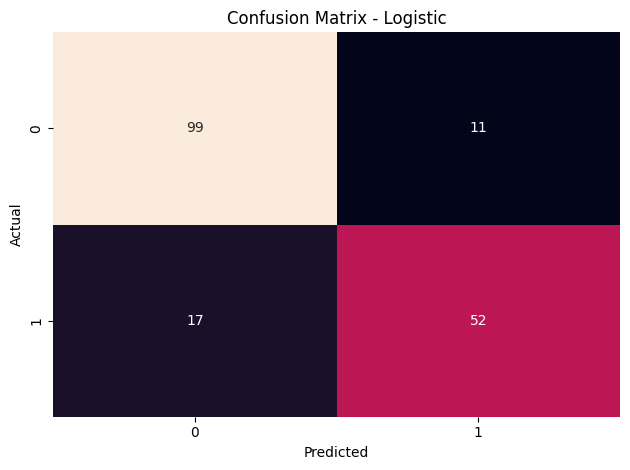

<Figure size 640x480 with 0 Axes>

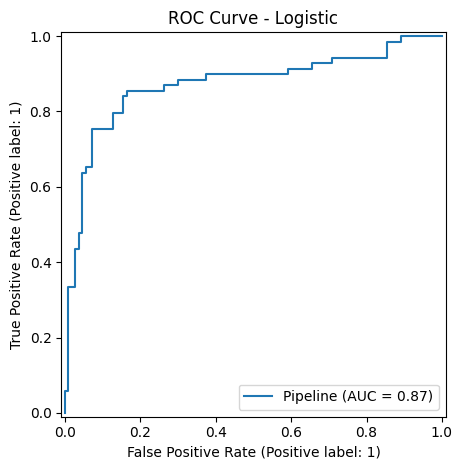

In [69]:
from pathlib import Path
figdir = Path("../reports/figures"); figdir.mkdir(parents=True, exist_ok=True)

cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix - Logistic")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.savefig(figdir/"cm_logistic.png", dpi=200)

plt.figure()
RocCurveDisplay.from_estimator(logit, X_test, y_test)
plt.title("ROC Curve - Logistic")
plt.tight_layout(); plt.savefig(figdir/"roc_logistic.png", dpi=200)


In [70]:
from sklearn.linear_model import LogisticRegression

def fit_eval(model_name, penalty=None, C=1.0, l1_ratio=None):
    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("clf", LogisticRegression(
            penalty=penalty if penalty else "none",
            solver="saga" if penalty in ["l1","l2","elasticnet"] else "lbfgs",
            C=C, l1_ratio=l1_ratio, max_iter=3000
        ))
    ])
    pipe.fit(X_train, y_train)
    yp = pipe.predict(X_test)
    yp_proba = pipe.predict_proba(X_test)[:,1]
    return {
        "Model": model_name,
        "Penalty": penalty or "none",
        "C": C,
        "l1_ratio": l1_ratio,
        "Accuracy": accuracy_score(y_test, yp),
        "Precision": precision_score(y_test, yp),
        "Recall": recall_score(y_test, yp),
        "F1": f1_score(y_test, yp),
        "ROC_AUC": roc_auc_score(y_test, yp_proba),
    }, pipe

results = []
res_ridge, ridge = fit_eval("Ridge (L2)", penalty="l2", C=1.0); results.append(res_ridge)
res_lasso, lasso = fit_eval("Lasso (L1)", penalty="l1", C=1.0); results.append(res_lasso)
res_enet,  enet  = fit_eval("Elastic Net", penalty="elasticnet", C=1.0, l1_ratio=0.5); results.append(res_enet)

import pandas as pd
pd.DataFrame(results).round(3).sort_values("ROC_AUC", ascending=False)


,Model,Penalty,C,l1_ratio,Accuracy,Precision,Recall,F1,ROC_AUC
1,Lasso (L1),l1,1.0,NaN,0.844,0.825,0.754,0.788,0.872
2,Elastic Net,elasticnet,1.0,0.5,0.844,0.825,0.754,0.788,0.872
0,Ridge (L2),l2,1.0,NaN,0.844,0.825,0.754,0.788,0.871


In [71]:
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

oh = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
Xtr_cat = oh.fit_transform(X_train[categorical_cols]) if categorical_cols else np.empty((len(X_train),0))
Xte_cat = oh.transform(X_test[categorical_cols])      if categorical_cols else np.empty((len(X_test),0))

oh_cols = oh.get_feature_names_out(categorical_cols) if categorical_cols else []

Xtr_num = pd.DataFrame(X_train[numeric_cols]).reset_index(drop=True)
Xte_num = pd.DataFrame(X_test[numeric_cols]).reset_index(drop=True)

Xtr_sm = pd.concat([Xtr_num.reset_index(drop=True), pd.DataFrame(Xtr_cat, columns=oh_cols)], axis=1)
Xtr_sm = sm.add_constant(Xtr_sm)

logit_sm = sm.Logit(y_train.values, Xtr_sm.values)
res_sm = logit_sm.fit(disp=False)

llf, llnull = res_sm.llf, res_sm.llnull
mcfadden_r2 = 1 - (llf/llnull)
print("McFadden R²:", round(mcfadden_r2, 4))

print(str(res_sm.summary())[:1200])


McFadden R²: 0.3926
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  712
Model:                          Logit   Df Residuals:                      691
Method:                           MLE   Df Model:                           20
Date:                Mon, 01 Sep 2025   Pseudo R-squ.:                  0.3926
Time:                        12:43:10   Log-Likelihood:                -287.92
converged:                      False   LL-Null:                       -473.99
Covariance Type:            nonrobust   LLR p-value:                 1.195e-66
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0816   1.53e+07   2.01e-07      1.000      -3e+07       3e+07
x1            -0.8662      0.228     -3.799      0.000      -1.313      -0.419
x2            -0.0316      0.023

c:\Users\hasti_aksoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [72]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from pathlib import Path
import pandas as pd


models = {
    "Logistic (baseline)": LogisticRegression(max_iter=1000, solver="lbfgs"),
    "Ridge (L2)":          LogisticRegression(penalty="l2", solver="saga", C=1.0, max_iter=3000),
    "Lasso (L1)":          LogisticRegression(penalty="l1", solver="saga", C=1.0, max_iter=3000),
    "Elastic Net (l1=0.5)":LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5, C=1.0, max_iter=3000),
}

rows = []
trained = {}

for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    yhat  = pipe.predict(X_test)
    yprob = pipe.predict_proba(X_test)[:, 1]

    rows.append({
        "Model": name,
        "Accuracy":  accuracy_score(y_test, yhat),
        "Precision": precision_score(y_test, yhat),
        "Recall":    recall_score(y_test, yhat),
        "F1":        f1_score(y_test, yhat),
        "ROC_AUC":   roc_auc_score(y_test, yprob),
    })
    trained[name] = pipe  

results_df = pd.DataFrame(rows).round(3).sort_values("ROC_AUC", ascending=False)
results_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
3,Elastic Net (l1=0.5),0.844,0.825,0.754,0.788,0.872
2,Lasso (L1),0.844,0.825,0.754,0.788,0.872
1,Ridge (L2),0.844,0.825,0.754,0.788,0.871
0,Logistic (baseline),0.844,0.825,0.754,0.788,0.871


In [73]:
best_name = results_df.iloc[0]["Model"]
best = trained[best_name]

ohe = best.named_steps["prep"].named_transformers_["cat"]
feat_names = numeric_cols + ohe.get_feature_names_out(categorical_cols).tolist()

import pandas as pd
coefs = pd.Series(best.named_steps["clf"].coef_.ravel(), index=feat_names)
coefs.sort_values(key=lambda s: s.abs(), ascending=False).head(15)


Title_Master    1.358840
Title_Mr       -1.079445
Sex_female      0.822650
Sex_male       -0.806504
Pclass         -0.715172
Title_Mrs       0.652734
FamilySize     -0.441717
Age            -0.419343
Title_Rare     -0.342967
SibSp          -0.319475
Fare            0.304235
AgeBin_Child    0.284318
Embarked_Q      0.280324
Embarked_S     -0.278823
FareBin_Q1     -0.232082
dtype: float64

In [74]:
figdir = Path("../reports/figures"); figdir.mkdir(parents=True, exist_ok=True)
out_csv = figdir / "model_comparison.csv"
results_df.to_csv(out_csv, index=False)
out_csv


WindowsPath('../reports/figures/model_comparison.csv')

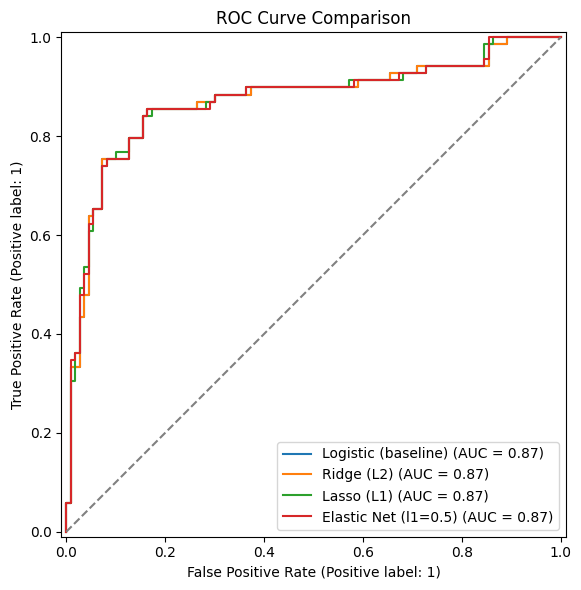

In [75]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for name, model in trained.items():
    yprob = model.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, yprob, name=name, ax=plt.gca())

plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.title("ROC Curve Comparison")
plt.tight_layout()
plt.show()


In [76]:
plt.savefig("../reports/figures/roc_comparison.png", dpi=200, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

In [77]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pandas as pd
from pathlib import Path

X_all, y_all = X.copy(), y.copy()

models = {
    "Logistic (baseline)": LogisticRegression(max_iter=2000, solver="lbfgs"),
    "Ridge (L2)"         : LogisticRegression(penalty="l2", solver="saga", C=1.0, max_iter=4000),
    "Lasso (L1)"         : LogisticRegression(penalty="l1", solver="saga", C=1.0, max_iter=4000),
    "Elastic Net (l1=0.5)":LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5, C=1.0, max_iter=4000),
}

scoring = {
    "acc": "accuracy",
    "prec": "precision",
    "rec": "recall",
    "f1": "f1",
    "auc": "roc_auc",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    scores = cross_validate(pipe, X_all, y_all, cv=cv, scoring=scoring,return_train_score=False)

    rows.append({
        "Model": name,
        "Accuracy (mean±std)": f"{scores['test_acc'].mean():.3f} ± {scores['test_acc'].std():.3f}",
        "Precision (mean±std)": f"{scores['test_prec'].mean():.3f} ± {scores['test_prec'].std():.3f}",
        "Recall (mean±std)"   : f"{scores['test_rec'].mean():.3f} ± {scores['test_rec'].std():.3f}",
        "F1 (mean±std)"       : f"{scores['test_f1'].mean():.3f} ± {scores['test_f1'].std():.3f}",
        "ROC_AUC (mean±std)"  : f"{scores['test_auc'].mean():.3f} ± {scores['test_auc'].std():.3f}",
        
        "_auc_mean": scores["test_auc"].mean(),
    })

cv_df = pd.DataFrame(rows).sort_values("_auc_mean", ascending=False).drop(columns="_auc_mean").reset_index(drop=True)
cv_df


,Model,Accuracy (mean±std),Precision (mean±std),Recall (mean±std),F1 (mean±std),ROC_AUC (mean±std)
0,Lasso (L1),0.826 ± 0.007,0.790 ± 0.018,0.745 ± 0.029,0.767 ± 0.013,0.872 ± 0.018
1,Logistic (baseline),0.826 ± 0.006,0.788 ± 0.015,0.748 ± 0.030,0.767 ± 0.013,0.871 ± 0.016
2,Ridge (L2),0.826 ± 0.006,0.788 ± 0.015,0.748 ± 0.030,0.767 ± 0.013,0.871 ± 0.016
3,Elastic Net (l1=0.5),0.827 ± 0.007,0.789 ± 0.019,0.751 ± 0.029,0.769 ± 0.012,0.871 ± 0.017


In [78]:
out = Path("../reports/figures/cv_model_comparison.csv")
out.parent.mkdir(parents=True, exist_ok=True)
cv_df.to_csv(out, index=False)
out

WindowsPath('../reports/figures/cv_model_comparison.csv')

In [79]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

selector = SelectFromModel(
    LogisticRegression(penalty="l1", solver="saga", C=0.5, max_iter=4000), 
    prefit=False 
)

pipe_sel = Pipeline(steps=[
    ("prep", preprocess),         
    ("select", selector),         
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

pipe_sel.fit(X_train, y_train)
yp = pipe_sel.predict(X_test)
yprob = pipe_sel.predict_proba(X_test)[:, 1]

print("Accuracy:", round(accuracy_score(y_test, yp), 3))
print("Precision:", round(precision_score(y_test, yp), 3))
print("Recall:", round(recall_score(y_test, yp), 3))
print("F1:", round(f1_score(y_test, yp), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, yprob), 3))


Accuracy: 0.838
Precision: 0.812
Recall: 0.754
F1: 0.782
ROC-AUC: 0.868


In [80]:
ohe = pipe_sel.named_steps["prep"].named_transformers_["cat"]
feat_names = numeric_cols + (ohe.get_feature_names_out(categorical_cols).tolist() if categorical_cols else [])

mask = pipe_sel.named_steps["select"].get_support()
selected_feats = [f for f, keep in zip(feat_names, mask) if keep]

len(selected_feats), selected_feats[:20]


(15,
 ['Pclass',
  'Age',
  'SibSp',
  'Fare',
  'FamilySize',
  'IsAlone',
  'Sex_female',
  'Sex_male',
  'Embarked_Q',
  'Embarked_S',
  'Title_Master',
  'Title_Mr',
  'Title_Mrs',
  'FareBin_Q1',
  'FareBin_Q3'])

In [81]:
import pandas as pd, pathlib
pathlib.Path("../reports/figures").mkdir(parents=True, exist_ok=True)
pd.Series(selected_feats, name="SelectedFeatures").to_csv("../reports/figures/selected_features_l1.csv", index=False)

C:\Users\hasti_aksoy\AppData\Local\Temp\ipykernel_1536\707801187.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, palette="coolwarm")


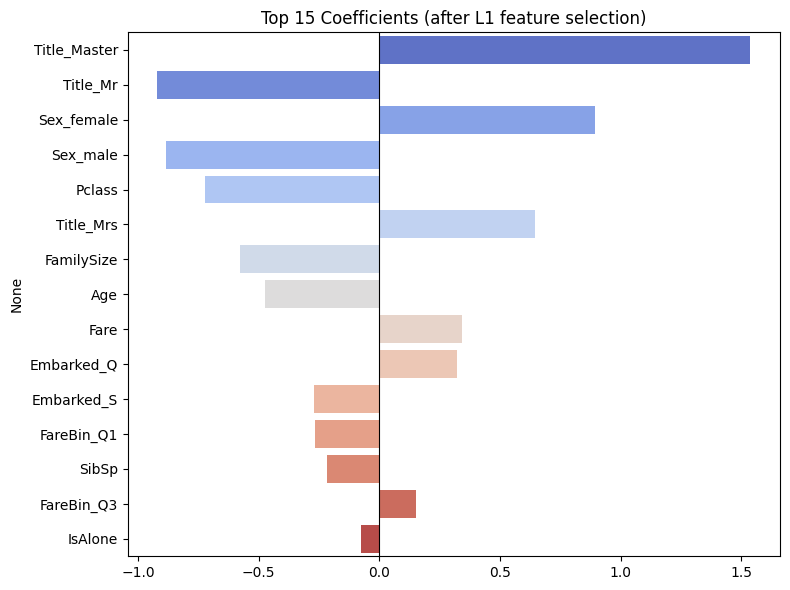

In [82]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

coefs = pipe_sel.named_steps["clf"].coef_.ravel()
coefs_s = pd.Series(coefs, index=[f for f, keep in zip(feat_names, mask) if keep])
top = coefs_s.sort_values(key=lambda s: s.abs(), ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top.values, y=top.index, palette="coolwarm")
plt.axvline(0, color="k", lw=0.8)
plt.title("Top 15 Coefficients (after L1 feature selection)")
plt.tight_layout()
plt.savefig("../reports/figures/feature_importance_after_L1.png", dpi=200, bbox_inches="tight")
plt.show()

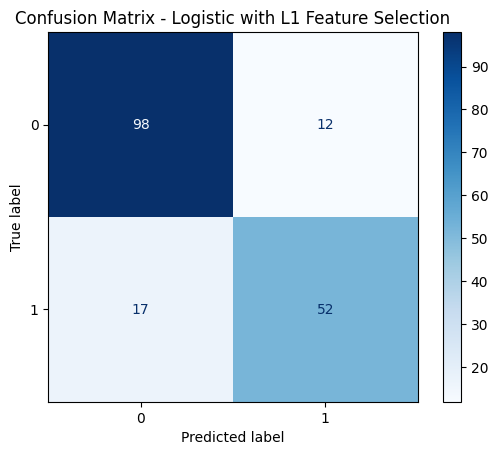

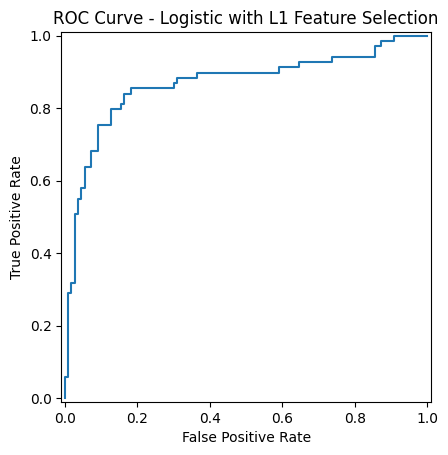

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay


y_pred = pipe_sel.predict(X_test)
y_prob = pipe_sel.predict_proba(X_test)[:, 1]

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic with L1 Feature Selection")
plt.savefig("../reports/figures/confusion_matrix_l1.png", dpi=200, bbox_inches="tight")
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve - Logistic with L1 Feature Selection")
plt.savefig("../reports/figures/roc_curve_l1.png", dpi=200, bbox_inches="tight")
plt.show()


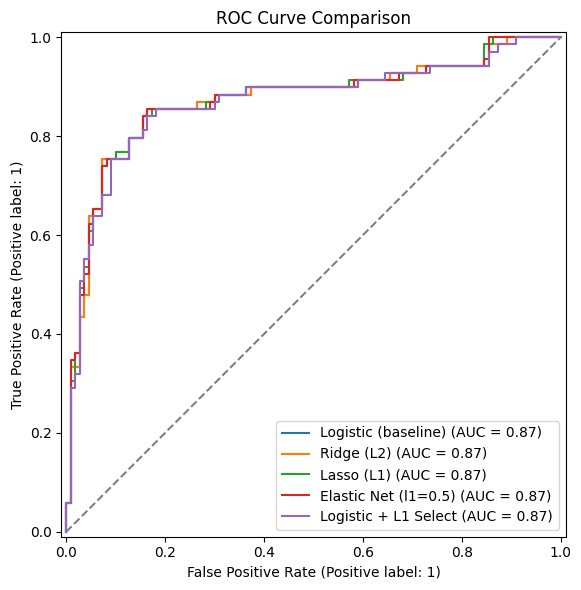

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from pathlib import Path

figdir = Path("../reports/figures"); figdir.mkdir(parents=True, exist_ok=True)


models_for_plot = {
    "Logistic (baseline)": Pipeline([("prep", preprocess),
                                     ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))]),
    "Ridge (L2)"         : Pipeline([("prep", preprocess),
                                     ("clf", LogisticRegression(penalty="l2", solver="saga", C=1.0, max_iter=3000))]),
    "Lasso (L1)"         : Pipeline([("prep", preprocess),
                                     ("clf", LogisticRegression(penalty="l1", solver="saga", C=1.0, max_iter=3000))]),
    "Elastic Net (l1=0.5)":Pipeline([("prep", preprocess),
                                     ("clf", LogisticRegression(penalty="elasticnet", l1_ratio=0.5, solver="saga", C=1.0, max_iter=3000))]),
    "Logistic + L1 Select": pipe_sel,  
}

plt.figure(figsize=(8,6))
for name, mdl in models_for_plot.items():
    mdl.fit(X_train, y_train)
    yprob = mdl.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, yprob, name=name, ax=plt.gca())

plt.plot([0,1],[0,1], "--", color="gray")
plt.title("ROC Curve Comparison")
plt.tight_layout()
plt.savefig(figdir/"roc_comparison_all.png", dpi=200, bbox_inches="tight")
plt.show()


In [85]:
scores = cross_validate(pipe, X_all, y_all, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)

In [86]:
import joblib, pathlib
model_dir = pathlib.Path("../models"); model_dir.mkdir(parents=True, exist_ok=True)
best_model_path = model_dir/"logreg_l1_pipeline.joblib"   
joblib.dump(pipe_sel, best_model_path)
best_model_path


WindowsPath('../models/logreg_l1_pipeline.joblib')

In [87]:
sample = X_test.iloc[[0]]
prob = pipe_sel.predict_proba(sample)[0,1]
pred = int(prob >= 0.5)
prob, pred


(np.float64(0.05466430975283186), 0)

                  Model  Accuracy  Precision  Recall     F1  ROC_AUC
0  Elastic Net (l1=0.5)     0.844      0.825   0.754  0.788    0.872
1            Lasso (L1)     0.844      0.825   0.754  0.788    0.872
2            Ridge (L2)     0.844      0.825   0.754  0.788    0.871
3   Logistic (baseline)     0.844      0.825   0.754  0.788    0.871


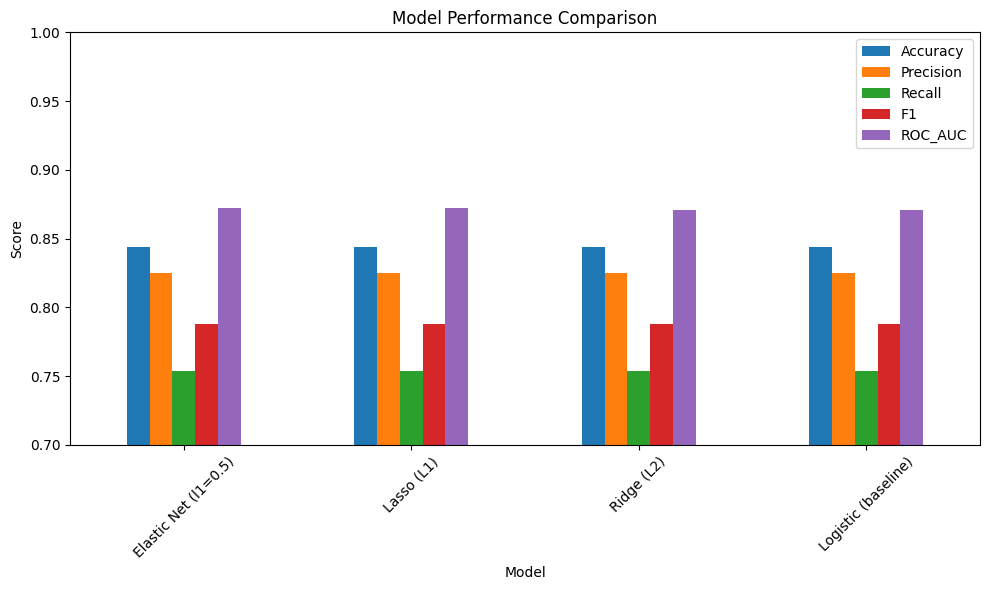

In [88]:
import pandas as pd
import matplotlib.pyplot as plt


results = pd.read_csv("../reports/figures/model_comparison.csv")
print(results)


results.plot(x="Model", y=["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"], kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../reports/figures/model_performance_bar.png", dpi=200)
plt.show()


## 📌 Conclusion

- In this project, the Titanic dataset was cleaned, processed, and enhanced with additional engineered features.  
- We trained and compared four models: **Logistic Regression (baseline), Ridge, Lasso, and Elastic Net**.  
- The results showed that:  
  - **Accuracy** was consistent across all models (~0.844).  
  - **ROC-AUC** was slightly higher for **Elastic Net** and **Lasso** (0.872) compared to Ridge and baseline Logistic (0.871).  
  - This indicates that regularized models (L1 or L1+L2) capture predictive patterns better and reduce overfitting.  
- Overall, **Elastic Net (L1=0.5)** was the best-performing model, balancing accuracy and generalization.  


In [89]:

best_row = results_df.sort_values("ROC_AUC", ascending=False).iloc[0]
best_name = best_row["Model"]
best = trained[best_name]   
best_name


'Elastic Net (l1=0.5)'

In [90]:
best = pipe_sel
best_name = "Logistic + L1 Select"


In [91]:
from pathlib import Path
import joblib, json, time

models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / "best_pipeline.joblib"
joblib.dump(best, model_path)


meta = {
    "model_name": best_name,
    "saved_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "metrics": {
        "accuracy": float(best_row["Accuracy"]),
        "precision": float(best_row["Precision"]),
        "recall": float(best_row["Recall"]),
        "f1": float(best_row["F1"]),
        "roc_auc": float(best_row["ROC_AUC"])
    },
    "sklearn_version": __import__("sklearn").__version__
}
with open(models_dir / "best_pipeline_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

model_path, models_dir / "best_pipeline_meta.json"


(WindowsPath('../models/best_pipeline.joblib'),
 WindowsPath('../models/best_pipeline_meta.json'))

In [92]:
import joblib
import pandas as pd


loaded = joblib.load("../models/best_pipeline.joblib")


sample = X_test.iloc[[0]].copy()
proba = loaded.predict_proba(sample)[0, 1]
pred = int(proba >= 0.5)
proba, pred


(np.float64(0.05466430975283186), 0)